In [1]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
print(tf.__version__)
AUTOTUNE = tf.data.experimental.AUTOTUNE

import deepcell
# Changed from before due to new placement of Track, concat_tracks
from deepcell_tracking.utils import load_trks
from deepcell.data.tracking import Track, concat_tracks
##############
from sklearn.model_selection import train_test_split
from deepcell.utils.data_utils import reshape_movie
from deepcell.utils.transform_utils import erode_edges
from deepcell.data import split_dataset
from deepcell_toolbox.processing import normalize, histogram_normalization

import spektral

2.8.0


# Write (complete, not pruned) appearances array to TF Records

In [2]:
import csv
import os

from tensorflow.data import Dataset
from tensorflow.io import serialize_tensor
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import is_sparse

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        # BytesList won't unpack a string from an EagerTensor.
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_array(array):
    array = tf.io.serialize_tensor(array)
    return array

def create_tracking_example(image):
    # define the dictionary -- the structure -- of our single example
    data = {
        'height' : _int64_feature(image.shape[0]),
        'width' : _int64_feature(image.shape[1]),
        'depth' : _int64_feature(image.shape[2]),
        'raw_image' : _bytes_feature(serialize_array(image))
    }
    # create an Example, wrapping the single features
    out = tf.train.Example(features=tf.train.Features(feature=data))
    
    return out

In [3]:
from skimage.exposure import rescale_intensity

def norm(X, size):
    X_norm = histogram_normalization(X, kernel_size=size)
    
    X_rescaled = np.zeros(X_norm.shape)
    for img_idx in range(X.shape[0]):
        x = X[img_idx]
        x = rescale_intensity(x, out_range=(0,1))
        X_rescaled[img_idx] = x
            
    return X_rescaled

In [8]:
def write_tracking_dataset_to_tfr(track, filename):
    app_type = track.appearances.dtype
    app = norm(track.appearances, 64).astype(app_type)
    print('Done calculating normalizations.')
    filename = "/data/tf_records/" + filename + ".tfrecords"
    writer = tf.io.TFRecordWriter(filename) #create a writer that'll store our data to disk
    count = 0

    # Only write usable images to the record
    for b in range(app.shape[0]):
        print(b)
        for f in range(app.shape[1]):
            for c in range(app.shape[2]):
                # Not checking if the given image is usable
                current_image = app[b, f, c]

                out = create_tracking_example(current_image)

                if out is not None:
                    writer.write(out.SerializeToString())
                    count += 1

    writer.close()
    print(f'Wrote {count} elements to TFRecord')
    return count

In [5]:
train_trks = load_trks(os.path.join('/data/tracking-nuclear', 'train.trks'))
val_trks = load_trks(os.path.join('/data/tracking-nuclear', 'val.trks'))

In [9]:
with tf.device('/cpu:0'):
    val_tracks = Track(tracked_data=val_trks,
                   appearance_dim=64,
                   distance_threshold=64,
                   crop_mode='fixed')

    print('Done creating Track objects.')

    write_tracking_dataset_to_tfr(val_tracks, filename='val_big_full')

100%|███████████████████████████████████████████| 27/27 [02:32<00:00,  5.65s/it]


Done creating Track objects.
Done calculating normalizations.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
Wrote 531009 elements to TFRecord


In [10]:
with tf.device('/cpu:0'):
    train_tracks = Track(tracked_data=train_trks,
                   appearance_dim=64,
                   distance_threshold=64,
                   crop_mode='fixed')

    print('Done with creating Track objects.')

    write_tracking_dataset_to_tfr(train_tracks, filename='train_big_full')

 33%|██████████████▏                            | 30/91 [07:06<15:50, 15.59s/it]/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|███████████████████████████████████████████| 91/91 [16:35<00:

Done with creating Track objects.
Done calculating normalizations.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
Wrote 2616705 elements to TFRecord


# Load images from TF Records

In [6]:
def parse_tfr_element(element):
    #use the same structure as above; it's kinda an outline of the structure we now want to create
    data = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width':tf.io.FixedLenFeature([], tf.int64),
        'depth':tf.io.FixedLenFeature([], tf.int64),
        'raw_image' : tf.io.FixedLenFeature([], tf.string)
    }


    content = tf.io.parse_single_example(element, data)

    height = content['height']
    width = content['width']
    depth = content['depth']
    raw_image = content['raw_image']
    

    #get our 'feature'-- our image -- and reshape it appropriately
    feature = tf.io.parse_tensor(raw_image, out_type=tf.float32)
    feature = tf.reshape(feature, shape=[height,width,depth])
    return (feature, feature)

In [7]:
def get_dataset(filename, batch_size=1, buffer_size=256,
                    seed=None):
    #create the dataset
    dataset = tf.data.TFRecordDataset(filename)

    #pass every single feature through our mapping function
    dataset = dataset.map(
      parse_tfr_element
    )
    
    dataset = dataset.shuffle(buffer_size, seed=seed)

    dataset = dataset.repeat().batch(batch_size)
    
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [8]:
val_dataset = get_dataset("/data/tf_records/val_big.tfrecords", batch_size=100)
train_dataset = get_dataset("/data/tf_records/train_big.tfrecords", batch_size=100)

In [13]:
for sample in val_dataset.take(895):
    if np.any((sample[0] < 0)|(sample[0] > 1 )):
        print('Not normalized')

for sample in train_dataset.take(3838):
    if np.any((sample[0] < 0)|(sample[0] > 1 )):
        print('Not normalized')

In [9]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

In [11]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam

class VAE:
    
    def __init__(self, dim_z, kl_weight, learning_rate, n_filters, n_layers, side):
        # change dim from (28, 28, 1)
        self.dim_x = (side, side, 1)
        self.dim_z = dim_z
        self.kl_weight = kl_weight
        self.learning_rate = learning_rate
        self.n_filters = n_filters
        self.n_layers = n_layers
        self.side = side

    # Sequential API encoder
    def encoder_z(self):
        # define prior distribution for the code, which is an isotropic Gaussian
        prior = tfd.Independent(tfd.Normal(loc=tf.zeros(self.dim_z), scale=1.), 
                                reinterpreted_batch_ndims=1)
        # build layers argument for tfk.Sequential()
        input_shape = self.dim_x
        layers = [tfkl.InputLayer(input_shape=input_shape)]
        for i in range(self.n_layers):
            layers.append(tfkl.Conv2D(filters=self.n_filters, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Flatten())
        # the following two lines set the output to be a probabilistic distribution
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_z), 
                                 activation=None, name='z_params'))
        layers.append(tfpl.IndependentNormal(self.dim_z, 
            convert_to_tensor_fn=tfd.Distribution.sample, 
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=self.kl_weight), 
            name='z_layer'))
        return tfk.Sequential(layers, name='encoder')
    
    # Sequential API decoder
    def decoder_x(self):
        layers = [tfkl.InputLayer(input_shape=self.dim_z)]
        # probably 7 before since 28/2/2 = 7, so changing to 32/2/2 = 8
        frac = 2**self.n_layers
        layers.append(tfkl.Dense(int((self.side/frac)**2*32), activation=None))
        layers.append(tfkl.Reshape((int(self.side/frac),int(self.side/frac),32)))
        for i in range(self.n_layers):
            layers.append(tfkl.Conv2DTranspose(filters=self.n_filters, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=1, kernel_size=3, strides=1, 
                                           padding='same'))
        layers.append(tfkl.Flatten())
        # note that here we don't need 
        # `tfkl.Dense(tfpl.IndependentBernoulli.params_size(self.dim_x))` because 
        # we've restored the desired input shape with the last Conv2DTranspose layer
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_x), 
                                 activation=None, name='x_params'))
        layers.append(tfpl.IndependentNormal(self.dim_x,
            name='x_layer'))
        return tfk.Sequential(layers, name='decoder')
    
    def build_vae_keras_model(self):
        x_input = tfk.Input(shape=self.dim_x)
        encoder = self.encoder_z()
        decoder = self.decoder_x()
        z = encoder(x_input)

        # compile VAE model
        model = tfk.Model(inputs=x_input, outputs=decoder(z))
        model.compile(loss=negative_log_likelihood, 
                      optimizer=RAdam(lr=1e-3, clipnorm=0.001))
        return model

# the negative of log-likelihood for probabilistic output
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [12]:
# VAE with 4 encoding and decoding layers, 64 filters per convolution, KL-divergence weight 1
vae = VAE(1024, 1, 1e-3, 64, 4, 64)
AE = vae.build_vae_keras_model()

2022-08-14 19:59:46.429655: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [13]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from deepcell import train_utils

steps_per_epoch = 3838
validation_steps = 895
n_epochs = 10
model_path = '/data/models/big_img_4_layers'

train_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
      
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=True)
]

loss_history = AE.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks
)

Epoch 1/10


2022-08-14 19:59:49.604277: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


3838/3838 [==============================] - ETA: 0s - loss: -5745.3677
Epoch 1: val_loss improved from inf to 1137.14185, saving model to /data/models/big_img_4_layers
3838/3838 [==============================] - 105s 26ms/step - loss: -5745.3677 - val_loss: 1137.1418 - lr: 0.0010
Epoch 2/10
3838/3838 [==============================] - ETA: 0s - loss: -6833.5737
Epoch 2: val_loss did not improve from 1137.14185
3838/3838 [==============================] - 93s 24ms/step - loss: -6833.5737 - val_loss: 1171.0627 - lr: 0.0010
Epoch 3/10
3838/3838 [==============================] - ETA: 0s - loss: -6115.5391
Epoch 3: val_loss did not improve from 1137.14185
3838/3838 [==============================] - 93s 24ms/step - loss: -6115.5391 - val_loss: 2321.9543 - lr: 0.0010
Epoch 4/10
3838/3838 [==============================] - ETA: 0s - loss: -6716.9072
Epoch 4: val_loss improved from 1137.14185 to 1013.39319, saving model to /data/models/big_img_4_layers
3838/3838 [===========================

In [1]:
import matplotlib.pyplot as plt

x = np.array([train_tracks.appearances[0][2][16]])
xhat = AE(x).mean()

fig, ax = plt.subplots()
ax.imshow(x[0])

fig, ax = plt.subplots()
ax.imshow(xhat[0])

NameError: name 'np' is not defined

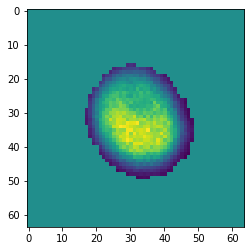

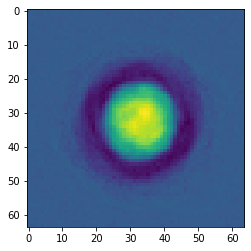

In [16]:
x = np.array([train_tracks.appearances[0][2][11]])
xhat = AE(x).mean()

fig, ax = plt.subplots()
ax.imshow(x[0])

fig, ax = plt.subplots()
ax.imshow(xhat[0])

In [28]:
type(xhat)

tensorflow.python.framework.ops.EagerTensor

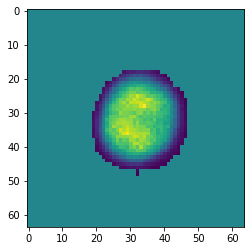

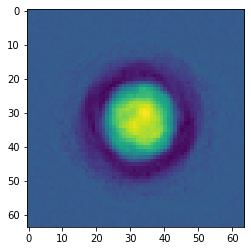

In [17]:
x = np.array([train_tracks.appearances[0][12][8]])
xhat = AE(x).mean()

fig, ax = plt.subplots()
ax.imshow(x[0])

fig, ax = plt.subplots()
ax.imshow(xhat[0])

In [12]:
# Compressing embedding space to 16 dimensions
vae_comp = VAE(16, 1, 1e-3, 64, 4, 64)
AE_comp = vae_comp.build_vae_keras_model()

2022-08-23 22:54:31.704047: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/optimizers/rectified_adam.py:120: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from deepcell import train_utils

steps_per_epoch = 3838
validation_steps = 895
n_epochs = 8
model_path = '/data/models/big_img_4_layers_comp_RAdam'

train_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
      
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=True)
]

loss_history = AE_comp.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks
)

Epoch 1/8


2022-08-23 22:55:01.031066: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


3838/3838 [==============================] - ETA: 0s - loss: 22999.0859
Epoch 1: val_loss improved from inf to -6000.75781, saving model to /data/models/big_img_4_layers_comp_RAdam
3838/3838 [==============================] - 237s 60ms/step - loss: 22999.0859 - val_loss: -6000.7578 - lr: 0.0010
Epoch 2/8
3838/3838 [==============================] - ETA: 0s - loss: 8133.9956
Epoch 2: val_loss improved from -6000.75781 to -6886.40723, saving model to /data/models/big_img_4_layers_comp_RAdam
3838/3838 [==============================] - 217s 56ms/step - loss: 8133.9956 - val_loss: -6886.4072 - lr: 0.0010
Epoch 3/8
3838/3838 [==============================] - ETA: 0s - loss: 1154.2805
Epoch 3: val_loss improved from -6886.40723 to -8277.78125, saving model to /data/models/big_img_4_layers_comp_RAdam
3838/3838 [==============================] - 213s 56ms/step - loss: 1154.2805 - val_loss: -8277.7812 - lr: 0.0010
Epoch 4/8
3838/3838 [==============================] - ETA: 0s - loss: 23776.736

In [14]:
val_good_imgs[2]

{0: {0: -1,
  1: -1,
  2: -1,
  3: -1,
  4: -1,
  5: -1,
  6: -1,
  7: -1,
  8: -1,
  9: -1,
  10: -1,
  11: -1,
  12: -1,
  13: -1,
  14: -1,
  15: -1,
  16: -1,
  17: -1,
  18: -1,
  19: -1,
  20: -1,
  21: -1,
  22: -1,
  23: -1,
  24: -1,
  25: -1,
  26: -1,
  27: -1,
  28: -1,
  29: -1,
  30: -1,
  31: -1,
  32: -1,
  33: -1,
  34: -1,
  35: -1,
  36: -1,
  37: -1,
  38: -1,
  39: -1,
  40: -1,
  41: -1,
  42: -1,
  43: -1,
  44: -1,
  45: -1,
  46: -1,
  47: -1,
  48: -1,
  49: -1,
  50: -1,
  51: -1,
  52: -1,
  53: -1,
  54: -1,
  55: -1,
  56: -1,
  57: -1,
  58: -1,
  59: -1,
  60: -1,
  61: -1,
  62: -1,
  63: -1,
  64: -1,
  65: -1,
  66: -1,
  67: -1,
  68: -1,
  69: -1,
  70: -1},
 1: {0: -1,
  1: -1,
  2: -1,
  3: -1,
  4: -1,
  5: -1,
  6: -1,
  7: -1,
  8: -1,
  9: -1,
  10: -1,
  11: -1,
  12: -1,
  13: -1,
  14: -1,
  15: 931,
  16: 932,
  17: 933,
  18: 934,
  19: 935,
  20: 936,
  21: 937,
  22: 938,
  23: 939,
  24: 940,
  25: 941,
  26: 942,
  27: 943,
  28: 944,

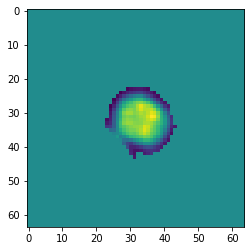

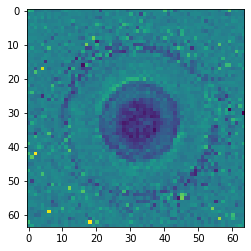

In [16]:
import matplotlib.pyplot as plt

x = np.array([val_tracks.appearances[2][25][1]])
xhat = AE_comp(x).mean()

fig, ax = plt.subplots()
ax.imshow(x[0])

fig, ax = plt.subplots()
ax.imshow(xhat[0])

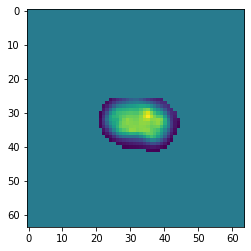

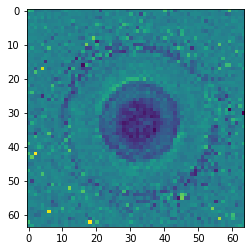

In [17]:
import matplotlib.pyplot as plt

x = np.array([val_tracks.appearances[2][13][6]])
xhat = AE_comp(x).mean()

fig, ax = plt.subplots()
ax.imshow(x[0])

fig, ax = plt.subplots()
ax.imshow(xhat[0])